In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn import Parameter, Module
from torchvision.datasets import MNIST
from torchvision import transforms

%matplotlib inline
use_cuda = torch.cuda.is_available()
if use_cuda:
    FloatTensor = torch.cuda.FloatTensor
else:
    FloatTensor = torch.FloatTensor

## Load data

In [2]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.], [1.0])])

trainset = MNIST(os.getenv("DATASET_MNIST"), train=True, transform=trans, download=True)
testset = MNIST(os.getenv("DATASET_MNIST"), train=False, transform=trans, download=True)

In [3]:
# NB: in their paper Auto-Encoding Variational Bayes, Kingma & Welling
# suggest that using a sufficiently large batch size allows for drawing
# only fewer samples from the variational posterior during learning
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=len(testset),
    shuffle=False,
    num_workers=4
)

# pre-load the test data (NB no `__next__` attribute on DataLoader?)
for (x, y) in test_loader:
    x_test = Variable(x.cuda() if use_cuda else x, volatile=True)
    y_test = Variable(y.cuda() if use_cuda else y, volatile=True)

## Define some global stuff

In [4]:
display_step = 1
n_epochs = 10
n_train_examples = len(trainset)
n_batches_per_epoch = int(n_train_examples / batch_size)
n_batches_total = n_batches_per_epoch * n_epochs
n_input = 784
n_classes = 10

print("Number of training examples:", n_train_examples)
print("Number of testing examples: ", len(testset))

Number of training examples: 60000
Number of testing examples:  10000


## Non-Bayesian Convolutional Neural Network (CNN)

In [5]:
class CNN(Module):
    """Four layer non-Bayesian neural network with two convolutional and
    two fully connected layers."""
    def __init__(self, n_in, n_conv1, n_conv2, n_fc1, n_out):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(n_in, n_conv1, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(n_conv1)
        self.conv2 = torch.nn.Conv2d(n_conv1, n_conv2, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(n_conv2)
        self.n_at_fc1 = 4*4*n_conv2  # NB manually calculated
        self.fc1 = torch.nn.Linear(self.n_at_fc1, n_fc1)
        self.fc2 = torch.nn.Linear(n_fc1, n_out)
        
    def forward(self, x):
        h = self.bn1(F.relu(self.conv1(x)))
        h = self.bn2(F.relu(self.conv2(h)))
        h = F.relu(self.fc1(h.view(-1, self.n_at_fc1)))
        return F.softmax(self.fc2(h), dim=1)

In [6]:
class MLP(Module):
    """Two layer non-Bayesian neural network."""
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_in, n_hidden)
        self.bn1 = torch.nn.BatchNorm1d(n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_out)
        
    def forward(self, x):
        h = self.bn1(F.relu(self.fc1(x.view(-1, 784))))
        return F.softmax(self.fc2(h), dim=1)

In [7]:
cnn = CNN(1, 10, 10, 100, 10)
if use_cuda:
    cnn = cnn.cuda()
opt = torch.optim.Adam(cnn.parameters())

### Training

* todo: try also using log_gaussian_logsig as loss function?

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x = Variable(x.cuda() if use_cuda else x)
        y = Variable(y.cuda() if use_cuda else y)
        
        preds = cnn(x)
        loss = loss_fn(preds, y)
        loss.backward()
        opt.step()

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        cnn_test_preds = cnn(x_test)
        loss = loss_fn(cnn_test_preds, y_test)
        cnn_test_correct = cnn_test_preds.max(dim=1)[1] == y_test
        cnn_test_acc = 100. * torch.mean(cnn_test_correct.data.float())
        print("[Epoch {:>3}]  |  Test err: {:>9} ({:>5}%)"
              .format(epoch+1, "%.5f" % loss.data[0], "%.2f" % cnn_test_acc))

[Epoch   1]  |  Test err:   1.49474 (97.09%)
[Epoch   2]  |  Test err:   1.48444 (97.81%)
[Epoch   3]  |  Test err:   1.47974 (98.25%)
[Epoch   4]  |  Test err:   1.48034 (98.18%)
[Epoch   5]  |  Test err:   1.47738 (98.50%)
[Epoch   6]  |  Test err:   1.47725 (98.48%)
[Epoch   7]  |  Test err:   1.47619 (98.58%)
[Epoch   8]  |  Test err:   1.47604 (98.56%)
[Epoch   9]  |  Test err:   1.47842 (98.28%)
[Epoch  10]  |  Test err:   1.47493 (98.63%)


In [9]:
cnn_indices_predicted_wrong = np.where(cnn_test_correct.data.cpu().numpy() == 0)[0]
print("Total incorrect on test set: %s" % len(cnn_indices_predicted_wrong))

Total incorrect on test set: 137


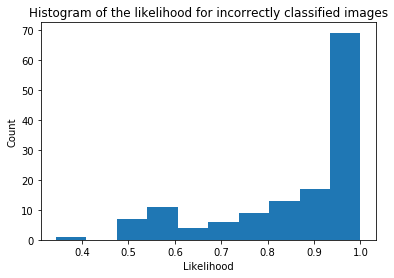

In [10]:
plt.hist(cnn_test_preds.max(dim=1)[0].data.cpu().numpy()[cnn_indices_predicted_wrong])
plt.title("Histogram of the likelihood for incorrectly classified images")
plt.xlabel("Likelihood")
plt.ylabel("Count")
plt.show()

## MLP

In [11]:
mlp = MLP(784, 200, 10)
if use_cuda:
    mlp = mlp.cuda()
opt = torch.optim.Adam(mlp.parameters())

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x = Variable(x.cuda() if use_cuda else x)
        y = Variable(y.cuda() if use_cuda else y)
        
        preds = mlp(x)
        loss = loss_fn(preds, y)
        loss.backward()
        opt.step()

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        mlp_test_preds = mlp(x_test)
        loss = loss_fn(mlp_test_preds, y_test)
        mlp_test_correct = mlp_test_preds.max(dim=1)[1] == y_test
        mlp_test_acc = 100. * torch.mean(mlp_test_correct.data.float())
        print("[Epoch {:>3}]  |  Test err: {:>9} ({:>5}%)"
              .format(epoch+1, "%.5f" % loss.data[0], "%.2f" % mlp_test_acc))

[Epoch   1]  |  Test err:   1.50953 (96.32%)
[Epoch   2]  |  Test err:   1.49547 (97.08%)
[Epoch   3]  |  Test err:   1.49155 (97.44%)
[Epoch   4]  |  Test err:   1.48795 (97.67%)
[Epoch   5]  |  Test err:   1.48615 (97.84%)
[Epoch   6]  |  Test err:   1.48534 (97.84%)
[Epoch   7]  |  Test err:   1.48471 (97.87%)
[Epoch   8]  |  Test err:   1.48246 (98.10%)
[Epoch   9]  |  Test err:   1.48246 (98.00%)
[Epoch  10]  |  Test err:   1.48177 (98.16%)


In [13]:
mlp_indices_predicted_wrong = np.where(mlp_test_correct.data.cpu().numpy() == 0)[0]
print("Total incorrect on test set: %s" % len(mlp_indices_predicted_wrong))

Total incorrect on test set: 184


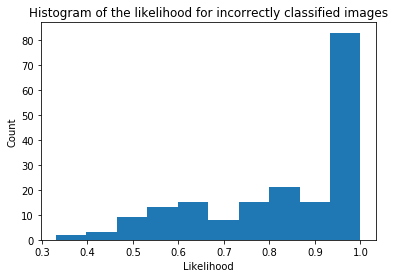

In [14]:
plt.hist(mlp_test_preds.max(dim=1)[0].data.cpu().numpy()[mlp_indices_predicted_wrong])
plt.title("Histogram of the likelihood for incorrectly classified images")
plt.xlabel("Likelihood")
plt.ylabel("Count")
plt.show()

# Going Bayesian

As described in the paper, the Bayes by Backprop algorithm can be implemented by minimising the _variational free energy_, instead of finding the maximum likelihood of the cross entropy error (in this case).

The variational free energy has the form:

$$
\begin{align}
F(D, \theta) &=
  \text{KL}[q(\mathbf{w}|\theta) || P(\mathbf{w})] −
  \mathbb{E}_{q(\mathbf{w}|\theta)} [\log P(D|\mathbf{w})]
\\
&\approx
  \sum_{i=1}^n \log q(\mathbf{w}^{(i)}|\theta) - \log P(\mathbf{w}^{(i)}) − \log P(D|\mathbf{w}^{(i)})
\end{align}
$$

where $\mathbf{w}^{(i)}$ is a monte carlo sample of the weights $\mathbf{w}$, $q(\mathbf{w}^{(i)}|\theta)$ represents the variational posterior, $P(\mathbf{w}^{(i)})$ is the prior and $P(D|\mathbf{w}^{(i)})$ is the likelihood.

In [15]:
class BayesParam(Module):
    """
    A `BayesParam` of shape `shape` contains values for both mu and
    log(sigma), and exposes methods/attributes for sampling, mean,
    log prior and log variational posterior.
    
    TODO: add posterior sharpening. This requires defining a custom
    gradient for this parameter, look at `register_backward_hook`
    """
    def __init__(self, shape, mu_init=0, logvar_init=-4):
        super().__init__()
        self.shape = shape
        
        # don't need random initialisation, we're doing random sampling anyway..
        self.mu = Parameter(FloatTensor(*shape).zero_() + mu_init)
        self.logvar = Parameter(FloatTensor(*shape).zero_() + logvar_init)
    
    def sample(self):
        # NB the paper uses log(1 + exp(sigma)) but we take a shortcut here
        # return self.mu + torch.exp(self.logsig) * self._eps(self.shape)
        return self.mu + self.logvar.mul(.5).exp_() * self._eps(self.shape)
    
    @staticmethod
    def _eps(shape):
        """Create a `Variable` of shape `shape` with values ~ N(0, 1)"""
        return Variable(FloatTensor(*shape).normal_())
    
    @property
    def kl(self):
        # analytical kl-divergence to a normal prior with mean 0 sd 1
        
        # kl_qp
        return -0.5 * torch.sum(1 + self.logvar - self.mu.pow(2) - self.logvar.exp())
        
        # kl_pq
        # return (self.logsig + (1 + self.mu**2) / (2 * torch.exp(self.logsig)**2)).sum()

In [16]:
class BayesModule(Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._bayes_objects = {}
    
    def __setattr__(self, name, value):
        """
        A very rudimentary copy of the functionality in `Module.__setattr__`.
        If the attribute being set is a `BayesParam` or a `BayesModule` (not
        including classes identical to `self` to avoid infinite recursion) then
        this function adds it to the instance attribute `_bayes_objects`.
        """
        super().__setattr__(name, value)
        if (
            isinstance(value, BayesParam) or
            (isinstance(value, BayesModule) and id(value) != id(self))
           ):
            self._bayes_objects[name] = value

    @property
    def kl(self):
        return torch.stack([x.kl for x in self._bayes_objects.values()]).sum()

In [17]:
class BayesLinear(BayesModule):
    """Linear fully connected NN layer using `BayesParam`s."""
    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.w = BayesParam([n_in, n_out])
        self.b = BayesParam([n_out])
    
    def forward(self, x, sample_q=True):
        if sample_q:
            # sample from the variational posterior
            w = self.w.sample()
            b = self.b.sample()
        else:
            # do not sample from the variational posterior (use mean instead)
            w = self.w.mu
            b = self.b.mu
        return x.mm(w) + b

In [18]:
class BayesConv(BayesModule):
    """Convolutional NN layer using `BayesParam`s."""
    def __init__(self, n_in, n_out, k_size=5, stride=2):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.stride = stride
        self.w = BayesParam([n_out, n_in, k_size, k_size])
        self.b = BayesParam([n_out])
    
    def forward(self, x, sample_q=True):
        if sample_q:
            # sample from the variational posterior
            w = self.w.sample()
            b = self.b.sample()
        else:
            # do not sample from the variational posterior (use mean instead)
            w = self.w.mu
            b = self.b.mu
        return F.conv2d(x, w, bias=b, stride=self.stride)

In [19]:
class BayesianMLP(BayesModule):
    """Two layer Bayesian MLP using `BayesLinear` layers."""
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.fc1 = BayesLinear(n_in, n_hidden)
        self.fc2 = BayesLinear(n_hidden, n_out)
        
    def forward(self, x, sample_q=True):
        h = F.relu(self.fc1(x.view(-1, 784), sample_q))
        return F.softmax(self.fc2(h, sample_q), dim=1)

In [20]:
class BayesianCNN(BayesModule):
    """Four layer Bayesian neural network with two convolutional and two
    fully connected layers."""
    def __init__(self, n_in, n_conv1, n_conv2, n_fc1, n_out):
        super().__init__()
        self.conv1 = BayesConv(n_in, n_conv1)
        self.conv2 = BayesConv(n_conv1, n_conv2)
        self.n_at_fc1 = 4*4*n_conv2  # NB manually calculated
        self.fc1 = BayesLinear(self.n_at_fc1, n_fc1)
        self.fc2 = BayesLinear(n_fc1, n_out)
        
    def forward(self, x, sample_q=True):
        h = F.relu(self.conv1(x, sample_q))
        h = F.relu(self.conv2(h, sample_q))
        h = F.relu(self.fc1(h.view(-1, self.n_at_fc1), sample_q))
        return F.softmax(self.fc2(h, sample_q), dim=1)

In [21]:
def pi(i, M):
    """Complexity coefficient for the loss function. The first few batches
    are dominated by the complexity loss, the later batches by data."""
    return 2**(M - i) / (2**M - 1)

# the prior for the log gaussian likelihood
# log_sigma_prior = Variable(FloatTensor([0]))

def one_hot(labels):
    onehot = Variable(FloatTensor(labels.size(0), n_classes).zero_())
    onehot.scatter_(1, labels.view(-1, 1), 1.0)
    return onehot

def loss_fn(coef, preds, y, kl):
    # NB cross entropy did not work.. :/ seems as though the likelihood loss
    # was dominating and the network behaved like a maximum likelihood model
    # log_likelihood = log_gaussian_logsig(one_hot(y), preds, log_sigma_prior).sum()
    bce = F.binary_cross_entropy(preds, one_hot(y), size_average=False)
    return (coef * kl + bce) / y.size(0)

## Bayesian MLP

In [22]:
bmlp = BayesianMLP(784, 200, 10)
if use_cuda:
    bmlp = bmlp.cuda()
opt = torch.optim.Adam(bmlp.parameters())

In [23]:
n_samples = 1
coef = 1 / n_batches_per_epoch

for epoch in range(n_epochs):
    rl = 0
    
    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x = Variable(x.cuda() if use_cuda else x)
        y = Variable(y.cuda() if use_cuda else y)
        
        # coef = pi(i, n_batches_total)        
        loss = 0
        for _ in range(n_samples):
            preds = bmlp(x)
            loss += loss_fn(coef, preds, y, bmlp.kl)
        
        (loss / n_samples).backward()
        opt.step()
        rl += (loss.data / n_samples) / n_batches_per_epoch

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        bmlp_test_preds = bmlp(x_test, sample_q=False)
        bmlp_test_correct = bmlp_test_preds.max(dim=1)[1] == y_test
        bmlp_test_acc = 100. * torch.mean(bmlp_test_correct.data.float())
        print(f"[Epoch {epoch+1:>3}]  |  Running loss: {float(rl):7.2f} ({bmlp_test_acc:4.2f}%)")

[Epoch   1]  |  Running loss:    6.98 (63.51%)
[Epoch   2]  |  Running loss:    4.85 (90.20%)
[Epoch   3]  |  Running loss:    4.02 (92.09%)
[Epoch   4]  |  Running loss:    3.59 (93.06%)
[Epoch   5]  |  Running loss:    3.20 (93.63%)
[Epoch   6]  |  Running loss:    2.88 (94.32%)
[Epoch   7]  |  Running loss:    2.60 (94.91%)
[Epoch   8]  |  Running loss:    2.38 (94.89%)
[Epoch   9]  |  Running loss:    2.20 (95.43%)
[Epoch  10]  |  Running loss:    2.05 (95.70%)


In [24]:
bmlp_indices_predicted_wrong = np.where(bmlp_test_correct.data.cpu().numpy() == 0)[0]
print("Total incorrect on test set: %s" % len(bmlp_indices_predicted_wrong))

Total incorrect on test set: 430


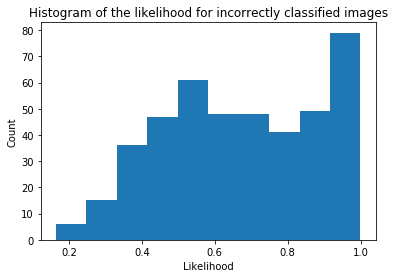

In [25]:
plt.hist(bmlp_test_preds.max(dim=1)[0].data.cpu().numpy()[bmlp_indices_predicted_wrong])
plt.title("Histogram of the likelihood for incorrectly classified images")
plt.xlabel("Likelihood")
plt.ylabel("Count")
plt.show()

## Bayesian CNN

In [26]:
bcnn = BayesianCNN(1, 10, 10, 100, 10)
if use_cuda:
    bcnn = bcnn.cuda()
opt = torch.optim.Adam(bcnn.parameters())

In [37]:
n_samples = 2
coef = 1 / n_batches_per_epoch

for epoch in range(n_epochs):
    rl = 0  # running loss
    
    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x = Variable(x.cuda() if use_cuda else x)
        y = Variable(y.cuda() if use_cuda else y)
        
        # coef = pi(i, n_batches_total)
        loss = 0
        for _ in range(n_samples):
            preds = bcnn(x)
            loss += loss_fn(coef, preds, y, bcnn.kl)
        
        (loss / n_samples).backward()
        opt.step()
        rl += (loss.data / n_samples) / n_batches_per_epoch

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        bcnn_test_preds = bcnn(x_test, sample_q=False)
        bcnn_test_correct = bcnn_test_preds.max(dim=1)[1] == y_test
        bcnn_test_acc = 100. * torch.mean(bcnn_test_correct.data.float())
        print(f"[Epoch {epoch+1:>3}]  |  Running loss: {float(rl):7.2f} ({bcnn_test_acc:4.2f}%)")

[Epoch   1]  |  Running loss:    1.03 (94.15%)
[Epoch   2]  |  Running loss:    0.89 (95.35%)
[Epoch   3]  |  Running loss:    1.57 (26.17%)
[Epoch   4]  |  Running loss:   49.52 (10.32%)
[Epoch   5]  |  Running loss:   50.05 (10.32%)
[Epoch   6]  |  Running loss:   49.99 (10.32%)
[Epoch   7]  |  Running loss:   50.06 (10.32%)
[Epoch   8]  |  Running loss:   50.04 (10.32%)
[Epoch   9]  |  Running loss:   50.06 (10.32%)
[Epoch  10]  |  Running loss:   50.05 (10.32%)


In [38]:
bcnn_indices_predicted_wrong = np.where(bcnn_test_correct.data.cpu().numpy() == 0)[0]
print("Total incorrect on test set: %s" % len(bcnn_indices_predicted_wrong))

Total incorrect on test set: 8968


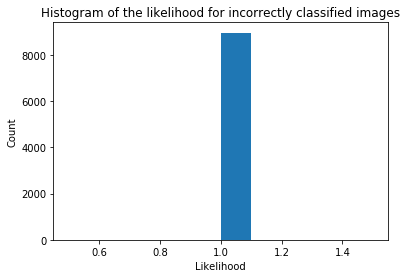

In [39]:
plt.hist(bcnn_test_preds.max(dim=1)[0].data.cpu().numpy()[bcnn_indices_predicted_wrong])
plt.title("Histogram of the likelihood for incorrectly classified images")
plt.xlabel("Likelihood")
plt.ylabel("Count")
plt.show()

## Let's test it on some unknown MNIST digits!

In [30]:
def get_likl_and_pred(tensor):
    l, p = tensor.max(dim=1)
    return float(l.data.cpu()[0]), float(p.data.cpu()[0])

def double_predict_and_plot(x, name, ax=None, cnn_output=None, bcnn_output=None):
    _input = trans(x.reshape((28, 28, 1))).view(1, 1, 28, 28)
    _input = Variable(_input.cuda() if use_cuda else _input, volatile=True)
    if cnn_output is None:
        cnn_output = cnn(_input)
    if bcnn_output is None:
        bcnn_output = bcnn(_input, sample_q=False)
    
    preds = {}
    preds["cnn_likl"], preds["cnn_pred"] = get_likl_and_pred(cnn_output)
    preds["bcnn_likl"], preds["bcnn_pred"] = get_likl_and_pred(bcnn_output)
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.imshow(x, cmap="gray", vmin=0, vmax=1)
    title = name + '\n'
    title += "bayesian: {bcnn_pred:.0f} with likelihood: {bcnn_likl:.2f}\n".format(**preds)
    title += "non-bayesian: {cnn_pred:.0f} with likelihood: {cnn_likl:.2f}".format(**preds)
    ax.set_title(title)
    ax.set_axis_off()
    return ax

### 1. A Blank Canvas

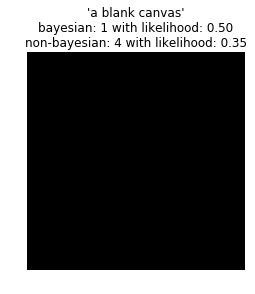

In [31]:
image = np.zeros((28, 28))
double_predict_and_plot(image, "'a blank canvas'")
plt.show()

### 2. A plus sign

Interestingly, this is consitently classified as a 4 with high likelihood! There is clearly a cross like pattern being found by both the Bayesian and non-Bayesian convolutional networks.

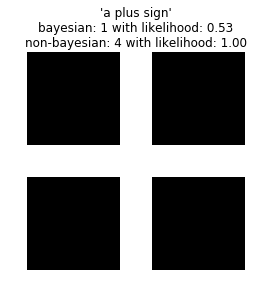

In [32]:
image[12:16, :] = 1.
image[:, 12:16] = 1.
double_predict_and_plot(image, "'a plus sign'")
plt.show()

### 3. All white

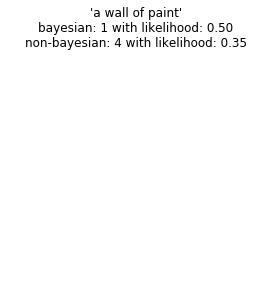

In [33]:
image[:, :] = 1.
double_predict_and_plot(image, "'a wall of paint'")
plt.show()

### 4. Random noise

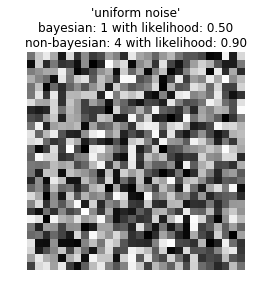

In [34]:
image = np.random.rand(28, 28)
double_predict_and_plot(image, "'uniform noise'")
plt.show()

# Compare wrongly classified examples

In [35]:
both_incorrect = np.intersect1d(
    cnn_indices_predicted_wrong,
    bcnn_indices_predicted_wrong
)

len(both_incorrect)

104

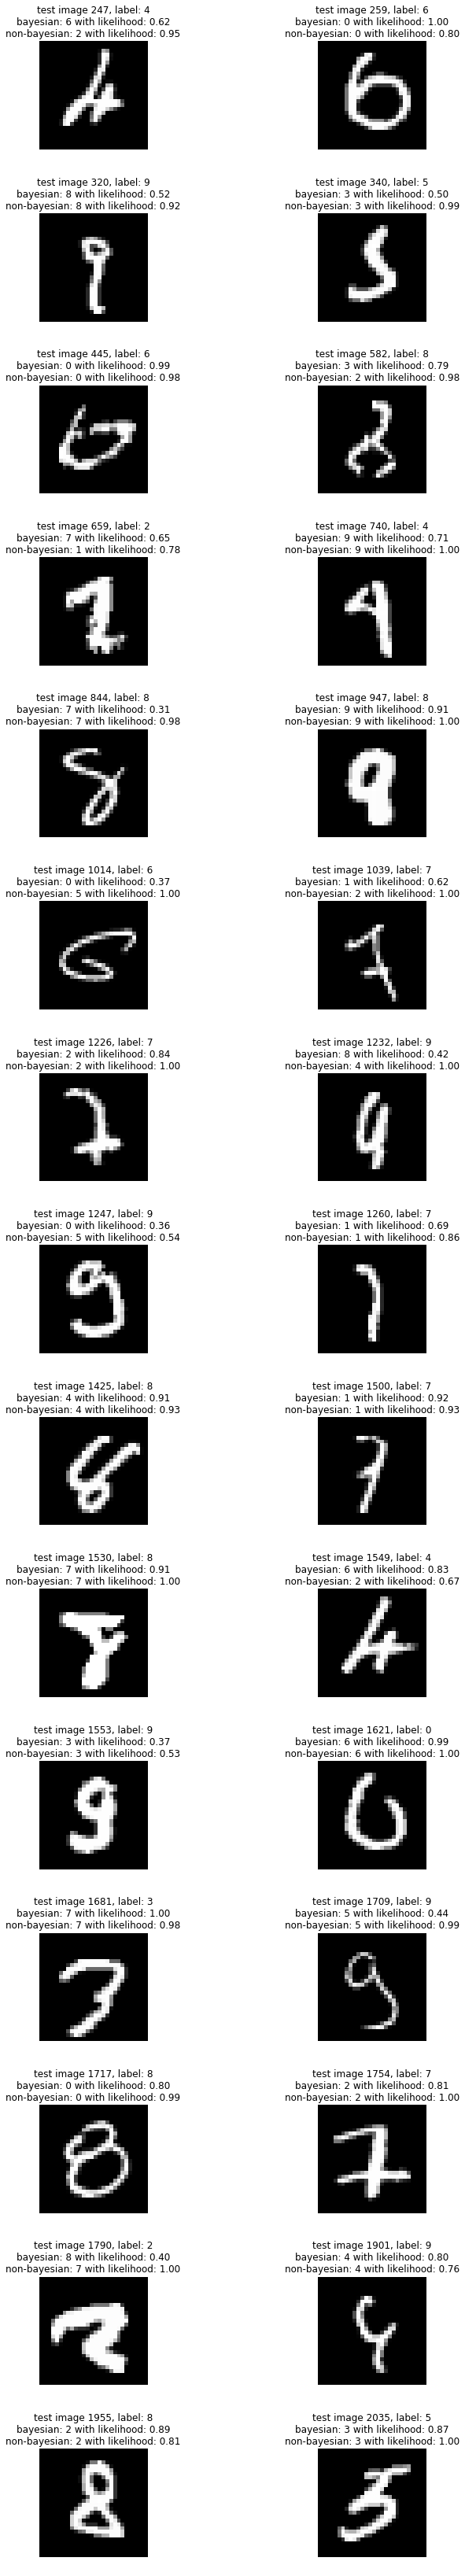

In [36]:
fig, axs = plt.subplots(15, 2, figsize=(10, 45))
fig.tight_layout(h_pad=6)

for i, ax in zip(both_incorrect[:30], axs.flatten()):
    image, label = testset[i]
    title = "test image %s, label: %s" % (i, label)
    double_predict_and_plot(
        image.numpy().reshape((28, 28)).astype("float64"),
        title,
        ax,
        cnn_output=cnn_test_preds[i].view(1, -1),
        bcnn_output=bcnn_test_preds[i].view(1, -1)
    )

plt.show()

There are clearly some examples where the Bayesian network still fails miserably (e.g. test image 2130 where a 4 is predicted as a 9 with 1.00 likelihood), and there are some examples where the non-Bayesian network appears more appropriate (e.g. test image 2293 where both networks misclassified a 9, but the non-Bayesian network gave only .40 likelihood compared to the Bayesian network's .82).

In general, however, it appears that by accounting for uncertainty on the network's weights, the Bayesian approach gives more reasonable likelihoods to misclassified images.

## Closing thoughts

In the context of self-driving cars or using neural networks in other life-endangering technologies there is a clear need for appropriately taking uncertainty into account. Studies such as pixel-attack show just how [easily a classifier can be fooled](https://www.theverge.com/2017/11/2/16597276/google-ai-image-attacks-adversarial-turtle-rifle-3d-printed), and this poses a serious risk, given that machine learning is being integrated into human life at a continuously increasing rate.